# Planejamento de movimento em região livre

## Dinâmica

Consideramos: $m=2$, $\delta t=1$, $\text{Origem}=(0,0)$ e a seguinte dinâmica:
$$
\begin{pmatrix}
x_{k+1}\\
y_{k+1}\\
\dot{x}_{k+1}\\
\dot{y}_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & \Delta t & 0\\
0 & 1 & 0 & \Delta t\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
x_k\\
y_k\\
\dot{x}_k\\
\dot{y}_k
\end{pmatrix}
+
\begin{pmatrix}
\frac{1}{2}\frac{(\Delta t)^2}{m} & 0\\
0 & \frac{1}{2}\frac{(\Delta t)^2}{m}\\
\frac{\Delta t}{m} & 0\\
0 & \frac{\Delta t}{m}
\end{pmatrix}
\begin{pmatrix}
F_{x,k}\\
F_{y,k}
\end{pmatrix}.
$$

## Modelo

$$
\begin{aligned}
\min \quad & C(x,u) \\
st. \quad & x_0=x_{start} \\
& x_N=x_{goal} \\
& x_{t+1}=Ax_t+Bu_t \quad \forall t 
\end{aligned}
$$

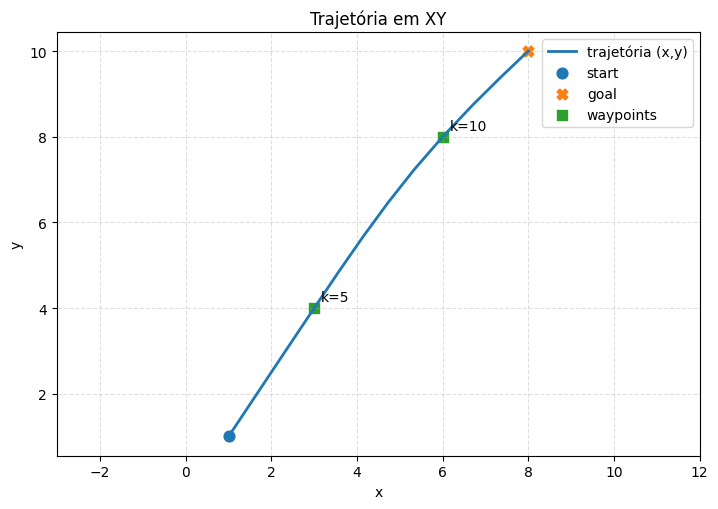

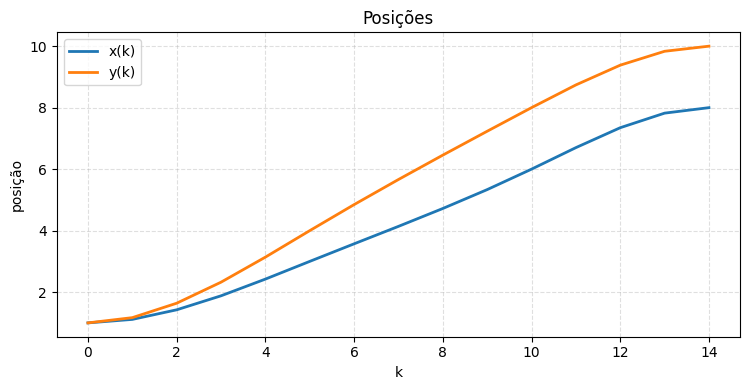

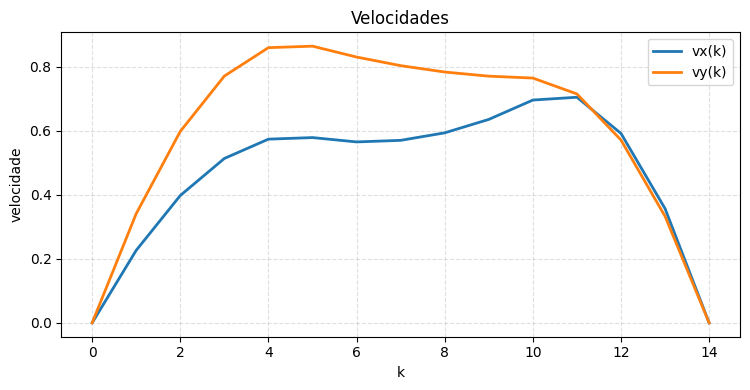

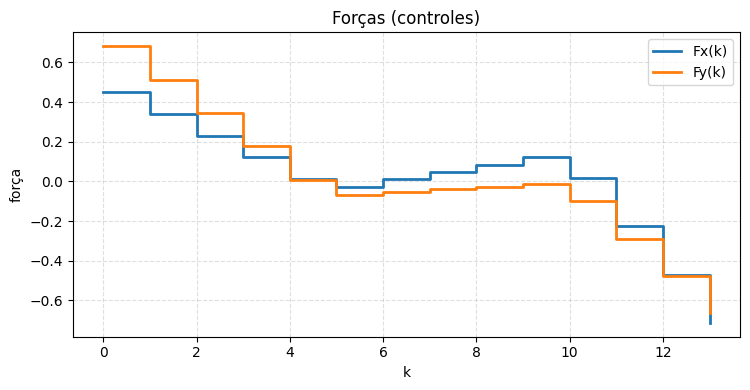

In [8]:
# -*- coding: utf-8 -*-
# Planejamento mínimo-energia em região livre (2D), estilo "meio-termo":
# - tempos como strings ('0', '1', ..., 'N')
# - variáveis separadas x,y,vx,vy,Fx,Fy com bounds
# - dinâmica consistente: forças só até N-1
# - objetivo: sum_{t=0}^{N-1} (Fx_t^2 + Fy_t^2)
#
# Requisitos: gurobipy, matplotlib, numpy (opcional p/ arrays)

from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Parâmetros
# ----------------------------
deltaT = 1.0
m = 2.0

N = 14                              # último índice de estado (N+1 estados, N etapas de controle)
times = [str(t) for t in range(N+1)]
times_u = times[:-1]                # instantes com força (0..N-1)

# limites (componente a componente)
vmin, vmax = -1.0, 1.0              # bounds de velocidade
fmin, fmax = -1.0, 1.0              # bounds de força

# condições de contorno
x0, y0, vx0, vy0 = 1.0, 1.0, 0.0, 0.0
xN, yN, vxN, vyN = 8.0, 10.0, 0.0, 0.0

# (Opcional) waypoints rígidos: dict {tempo_str: (xw, yw)}
WAYPOINTS = {
    '5': (3.0, 4.0),
    '10': (6.0, 8.0),
}

# ----------------------------
# Modelo
# ----------------------------
mdl = Model('Planner2D_minEnergy')

# Variáveis (todas indexadas por strings)
x  = mdl.addVars(times, name='x')                       # posição x_t
y  = mdl.addVars(times, name='y')                       # posição y_t
vx = mdl.addVars(times, lb=vmin, ub=vmax, name='vx')    # velocidade xdot_t
vy = mdl.addVars(times, lb=vmin, ub=vmax, name='vy')    # velocidade ydot_t
Fx = mdl.addVars(times_u, lb=fmin, ub=fmax, name='Fx')  # força Fx_t (0..N-1)
Fy = mdl.addVars(times_u, lb=fmin, ub=fmax, name='Fy')  # força Fy_t (0..N-1)

# Dinâmica (integrador duplo 2D com Δt=deltaT, massa m)
for t in times_u:
    tp1 = str(int(t) + 1)
    mdl.addConstr(x[tp1]  == x[t]  + vx[t]*deltaT + 0.5*(deltaT**2)*Fx[t]/m, name=f"x_dyn[{t}]")
    mdl.addConstr(y[tp1]  == y[t]  + vy[t]*deltaT + 0.5*(deltaT**2)*Fy[t]/m, name=f"y_dyn[{t}]")
    mdl.addConstr(vx[tp1] == vx[t] + (deltaT/m)*Fx[t],                            name=f"vx_dyn[{t}]")
    mdl.addConstr(vy[tp1] == vy[t] + (deltaT/m)*Fy[t],                            name=f"vy_dyn[{t}]")

# Contorno (start/goal)
mdl.addConstr(x[times[0]]  == x0,  name='x0')
mdl.addConstr(y[times[0]]  == y0,  name='y0')
mdl.addConstr(vx[times[0]] == vx0, name='vx0')
mdl.addConstr(vy[times[0]] == vy0, name='vy0')

mdl.addConstr(x[times[-1]]  == xN,  name='xN')
mdl.addConstr(y[times[-1]]  == yN,  name='yN')
mdl.addConstr(vx[times[-1]] == vxN, name='vxN')
mdl.addConstr(vy[times[-1]] == vyN, name='vyN')

# Waypoints rígidos (se houver)
for tw, (xw, yw) in WAYPOINTS.items():
    if tw in times and tw not in (times[0], times[-1]):
        mdl.addConstr(x[tw] == float(xw), name=f"wp_x[{tw}]")
        mdl.addConstr(y[tw] == float(yw), name=f"wp_y[{tw}]")

# Objetivo: energia mínima = soma dos quadrados das forças
mdl.setObjective(quicksum(Fx[t]*Fx[t] + Fy[t]*Fy[t] for t in times_u), GRB.MINIMIZE)  # Quadrático

mdl.setParam("OutputFlag", 0)  # silencioso; mude para 1 se quiser log
mdl.optimize()

# ----------------------------
# Coleta solução
# ----------------------------
xs  = [x[t].X for t in times]
ys  = [y[t].X for t in times]
vxs = [vx[t].X for t in times]
vys = [vy[t].X for t in times]
Fxs = [Fx[t].X for t in times_u]
Fys = [Fy[t].X for t in times_u]

k  = np.arange(len(times))
ku = np.arange(len(times_u))

# ----------------------------
# Plots
# ----------------------------

# (1) Trajetória XY + waypoints
plt.figure(figsize=(7.2, 5.2))
plt.plot(xs, ys, linewidth=2, label="trajetória (x,y)")
plt.scatter([x0], [y0], marker='o', s=60, label="start")
plt.scatter([xN], [yN], marker='X', s=60, label="goal")
if WAYPOINTS:
    wp_xy = np.array(list(WAYPOINTS.values()))
    plt.scatter(wp_xy[:,0], wp_xy[:,1], marker='s', s=50, label="waypoints")
    for tw,(xw,yw) in WAYPOINTS.items():
        plt.annotate(f"k={tw}", (xw, yw), textcoords="offset points", xytext=(5,5))
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel("x"); plt.ylabel("y"); plt.title("Trajetória em XY")
plt.legend()
plt.tight_layout()
plt.show()

# (2) Posições vs tempo
plt.figure(figsize=(7.6, 4.0))
plt.plot(k, xs, linewidth=2, label="x(k)")
plt.plot(k, ys, linewidth=2, label="y(k)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel("k"); plt.ylabel("posição")
plt.title("Posições")
plt.legend(); plt.tight_layout(); plt.show()

# (3) Velocidades vs tempo
plt.figure(figsize=(7.6, 4.0))
plt.plot(k, vxs, linewidth=2, label="vx(k)")
plt.plot(k, vys, linewidth=2, label="vy(k)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel("k"); plt.ylabel("velocidade")
plt.title("Velocidades")
plt.legend(); plt.tight_layout(); plt.show()

# (4) Forças vs tempo (degrau 'post' para controle em patamar)
plt.figure(figsize=(7.6, 4.0))
plt.step(ku, Fxs, where="post", linewidth=2, label="Fx(k)")
plt.step(ku, Fys, where="post", linewidth=2, label="Fy(k)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel("k"); plt.ylabel("força")
plt.title("Forças (controles)")
plt.legend(); plt.tight_layout(); plt.show()


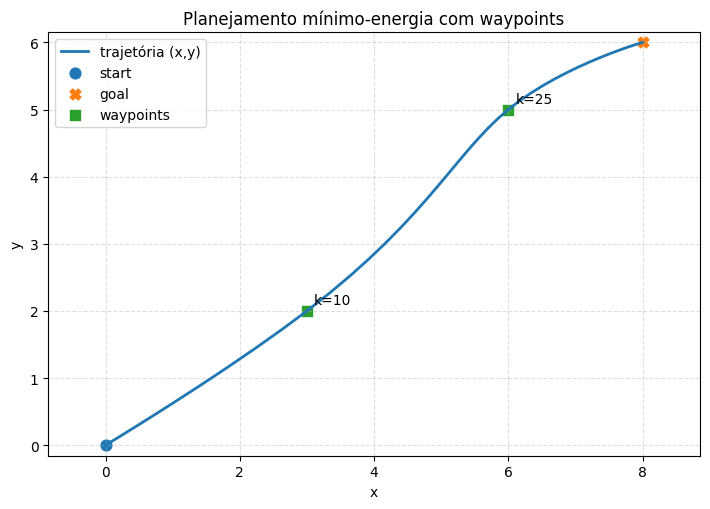

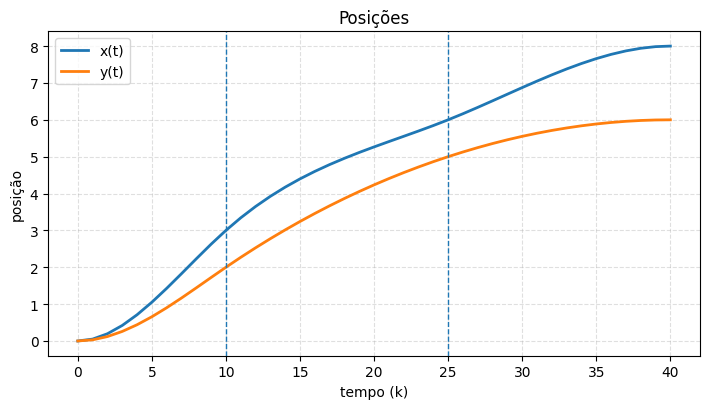

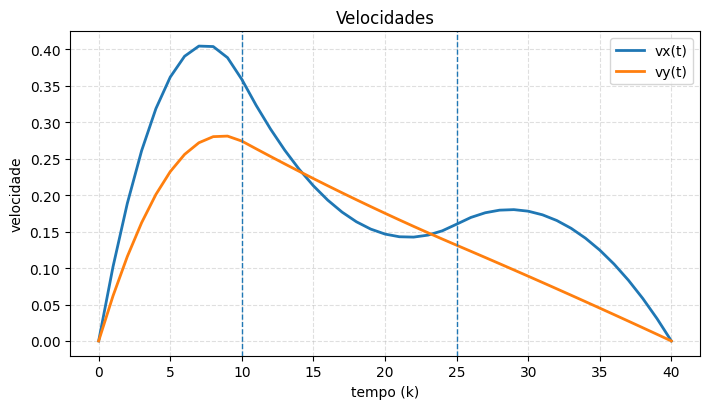

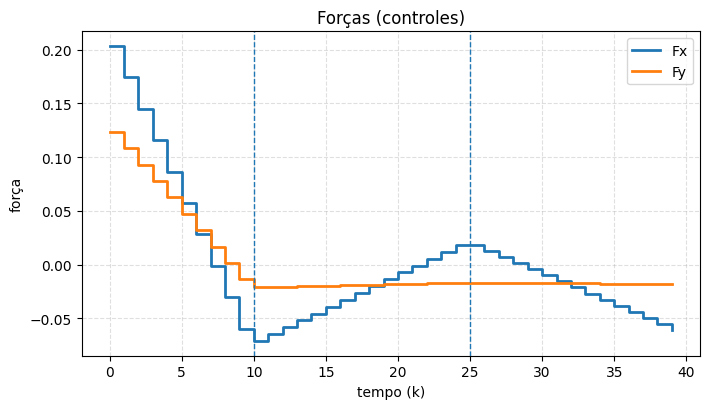

Waypoints usados: [(10, array([3., 2.])), (25, array([6., 5.]))]


In [7]:
# QP-based minimum-energy planner in free space for a 2D double integrator
# Now with optional WAYPOINT constraints AND waypoint plotting.
#
# Model:
#   m = 2, Δt = 1, x = [x, y, xdot, ydot], u = [Fx, Fy]
#   x_{k+1} = A x_k + B u_k
# Optimization (QP):
#   min Σ ||u_k||_2^2 + ε Σ ||x_k||_2^2
#   s.t. x_0 = x_start, x_N = x_goal, and (optional) x_{k_w}[0:2] = waypoint_{k_w}
#
# If Gurobi is not present, we compute a minimum-norm control via pseudoinverse
# that enforces terminal AND waypoint equalities, then simulate forward.
#
# Plots include the XY path, time-series, controls, and the waypoints as markers+labels.

import numpy as np
import matplotlib.pyplot as plt

def plan_min_energy_with_waypoints(
    N=40,
    dt=1.0,
    m=2.0,
    x_start=np.array([0.0, 0.0, 0.0, 0.0]),
    x_goal=np.array([8.0, 6.0, 0.0, 0.0]),
    waypoints=None,   # list of tuples (k_w, np.array([x_w, y_w]))
    epsilon_state=1e-6
):
    # Build A, B
    A = np.array([[1.0, 0.0, dt,  0.0],
                  [0.0, 1.0, 0.0, dt ],
                  [0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 1.0]])
    B = np.array([[0.5*dt*dt/m, 0.0],
                  [0.0, 0.5*dt*dt/m],
                  [dt/m, 0.0],
                  [0.0, dt/m]])

    # Normalize waypoint list
    wp_list = []
    if waypoints is not None:
        for k_w, pos in waypoints:
            k_w = int(k_w)
            pos = np.asarray(pos).reshape(2,)
            if 0 < k_w < N:  # only interior steps make sense for constraints
                wp_list.append((k_w, pos))

    # Try Gurobi QP
    try:
        import gurobipy as gp
        from gurobipy import GRB
        model = gp.Model("min_energy_2D_with_waypoints")
        model.setParam("OutputFlag", 0)

        x = model.addVars(N+1, 4, lb=-GRB.INFINITY, name="x")
        u = model.addVars(N, 2, lb=-GRB.INFINITY, name="u")

        # Initial and terminal constraints
        for i,val in enumerate(x_start):
            model.addConstr(x[0,i] == float(val))
        for i,val in enumerate(x_goal):
            model.addConstr(x[N,i] == float(val))

        # Waypoint constraints (positions only)
        for (k_w, pos) in wp_list:
            model.addConstr(x[k_w,0] == float(pos[0]))
            model.addConstr(x[k_w,1] == float(pos[1]))

        # Dynamics
        for k in range(N):
            for i in range(4):
                rhs = gp.LinExpr()
                for j in range(4):
                    rhs += A[i,j]*x[k,j]
                for j in range(2):
                    rhs += B[i,j]*u[k,j]
                model.addConstr(x[k+1,i] == rhs)

        # Objective: sum ||u_k||^2 + epsilon * sum ||x_k||^2
        obj = gp.QuadExpr()
        for k in range(N):
            obj += u[k,0]*u[k,0] + u[k,1]*u[k,1]
        if epsilon_state > 0:
            for k in range(N+1):
                obj += epsilon_state * (x[k,0]*x[k,0] + x[k,1]*x[k,1] + x[k,2]*x[k,2] + x[k,3]*x[k,3])
        model.setObjective(obj, GRB.MINIMIZE)
        model.optimize()

        if model.status != GRB.OPTIMAL:
            raise RuntimeError(f"Gurobi status {model.status}")

        x_sol = np.zeros((N+1,4))
        u_sol = np.zeros((N,2))
        for k in range(N+1):
            for i in range(4):
                x_sol[k,i] = x[k,i].X
        for k in range(N):
            for j in range(2):
                u_sol[k,j] = u[k,j].X

        solver_info = "Gurobi (QP optimal)"
        return A, B, x_sol, u_sol, solver_info, wp_list

    except Exception as e:
        # Fallback: least-norm control satisfying terminal + waypoint equalities
        # We will build a linear system M U = rhs, where U = [u_0; u_1; ...; u_{N-1}] in R^{2N}
        # and the constraints are linear in U via the reachability mapping.
        # Build powers of A
        A_powers = [np.eye(4)]
        for k in range(1, N+1):
            A_powers.append(A_powers[-1] @ A)

        # Helper to assemble a block row that maps U to x_k
        def reach_row_for_time(k):
            # x_k = A^k x0 + sum_{i=0}^{k-1} A^{k-1-i} B u_i
            # Build a (4 x 2N) block-row
            row = np.zeros((4, 2*N))
            for i in range(k):  # controls only up to k-1 affect x_k
                Gki = A_powers[k-1-i] @ B  # 4x2
                row[:, 2*i:2*i+2] = Gki
            return row

        # Stack constraints: terminal (all 4 states) + waypoints (2 positions each)
        M_rows = []
        rhs_list = []

        # Terminal constraint at k = N: x_N = x_goal
        PhiN = A_powers[N]
        M_N = reach_row_for_time(N)   # 4 x 2N
        M_rows.append(M_N)
        rhs_list.append((x_goal - PhiN @ x_start).reshape(4,))

        # Waypoint constraints
        for (k_w, pos) in wp_list:
            M_k = reach_row_for_time(k_w)        # 4 x 2N
            # Pick only position rows [0,1]
            M_rows.append(M_k[0:2, :])
            xk_free = A_powers[k_w] @ x_start
            rhs_list.append((np.array([pos[0], pos[1]]) - xk_free[0:2]).reshape(2,))

        # Build linear system
        if len(M_rows) == 1:
            M = M_rows[0]
            rhs = rhs_list[0]
        else:
            M = np.vstack(M_rows)     # (#eq) x (2N)
            rhs = np.concatenate(rhs_list)  # (#eq,)

        # Minimum-norm solution U = M^+ rhs
        U = np.linalg.pinv(M) @ rhs
        u_sol = U.reshape(N, 2)

        # Simulate forward to get x trajectory
        x_sol = np.zeros((N+1,4))
        x_sol[0,:] = x_start
        for k in range(N):
            x_sol[k+1,:] = A @ x_sol[k,:] + B @ u_sol[k,:]

        solver_info = f"Least-norm closed-form (pseudoinverse); fallback: {e}"
        return A, B, x_sol, u_sol, solver_info, wp_list


# ---- Demo with waypoints
N = 40
dt = 1.0
m  = 2.0
x_start = np.array([0.0, 0.0, 0.0, 0.0])        # origem
x_goal  = np.array([8.0, 6.0, 0.0, 0.0])        # objetivo

# Example waypoints: (time index, [x_w, y_w])
# Feel free to edit or set to [] to remove.
waypoints = [
    (10, np.array([3.0, 2.0])),
    (25, np.array([6.0, 5.0])),
]

A, B, x_sol, u_sol, solver_info, wp_used = plan_min_energy_with_waypoints(
    N=N, dt=dt, m=m, x_start=x_start, x_goal=x_goal,
    waypoints=waypoints, epsilon_state=1e-6
)

# ---- Plots
t_states = np.arange(N+1) * dt
t_ctrl   = np.arange(N)   * dt

# 1) XY path with waypoints
plt.figure(figsize=(7.2, 5.2))
plt.plot(x_sol[:,0], x_sol[:,1], linewidth=2, label="trajetória (x,y)")
plt.scatter([x_start[0]], [x_start[1]], marker='o', s=60, label="start")
plt.scatter([x_goal[0]],  [x_goal[1]],  marker='X', s=60, label="goal")
# plot waypoints
if len(wp_used) > 0:
    wp_x = [p[1][0] for p in wp_used]
    wp_y = [p[1][1] for p in wp_used]
    plt.scatter(wp_x, wp_y, s=50, marker='s', label="waypoints")
    # annotate with time index
    for (k_w, pos) in wp_used:
        plt.annotate(f"k={k_w}", (pos[0], pos[1]), textcoords="offset points", xytext=(5,5))
plt.title(f"Planejamento mínimo-energia com waypoints")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 2) x(t), y(t)
plt.figure(figsize=(7.2, 4.2))
plt.plot(t_states, x_sol[:,0], linewidth=2, label="x(t)")
plt.plot(t_states, x_sol[:,1], linewidth=2, label="y(t)")
# overlay waypoint times as vertical markers
for (k_w, pos) in wp_used:
    plt.axvline(k_w*dt, linestyle="--", linewidth=1)
plt.title("Posições")
plt.xlabel("tempo (k)")
plt.ylabel("posição")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 3) v_x(t), v_y(t)
plt.figure(figsize=(7.2, 4.2))
plt.plot(t_states, x_sol[:,2], linewidth=2, label="vx(t)")
plt.plot(t_states, x_sol[:,3], linewidth=2, label="vy(t)")
for (k_w, pos) in wp_used:
    plt.axvline(k_w*dt, linestyle="--", linewidth=1)
plt.title("Velocidades")
plt.xlabel("tempo (k)")
plt.ylabel("velocidade")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 4) F_x(t), F_y(t)
plt.figure(figsize=(7.2, 4.2))
plt.step(t_ctrl, u_sol[:,0], where="post", linewidth=2, label="Fx")
plt.step(t_ctrl, u_sol[:,1], where="post", linewidth=2, label="Fy")
for (k_w, pos) in wp_used:
    if 0 <= k_w < N:
        plt.axvline(k_w*dt, linestyle="--", linewidth=1)
plt.title("Forças (controles)")
plt.xlabel("tempo (k)")
plt.ylabel("força")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

print("Waypoints usados:", wp_used)


Restricted license - for non-production use only - expires 2026-11-23


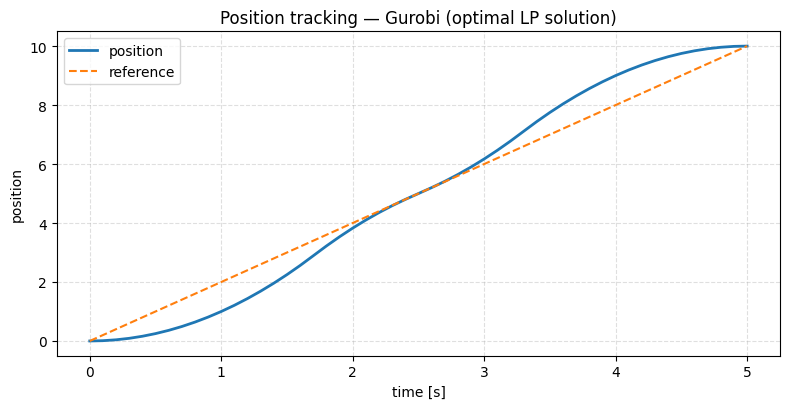

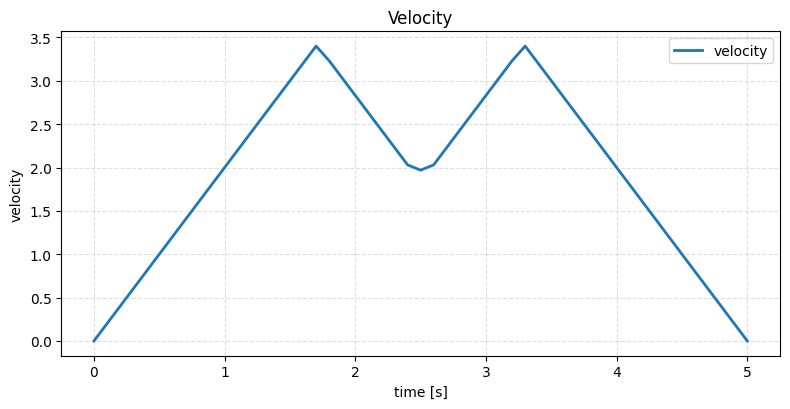

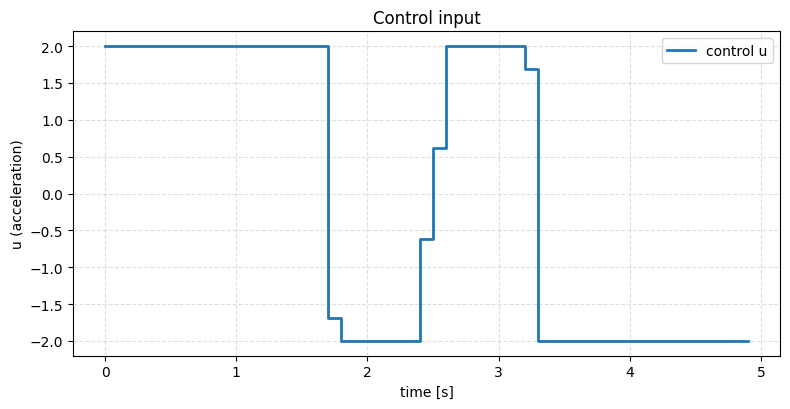

In [1]:
# LP-based MPC without obstacles (L1 magnitude + L1 smoothness + L1 tracking)
# Solver: Gurobi if available; otherwise, fall back to a didactic cubic-spline trajectory
# and still produce the plots. Plots follow the rule: one chart per figure, default colors.
#
# Model (discrete time):
#   x_{t+1} = A x_t + B u_t + d
# States x = [position, velocity] (double integrator), control u = acceleration.
# Objective:
#   min  alpha*sum |u_t| + beta*sum |u_t - u_{t-1}| + gamma*sum |x_t[0] - r_t|
# with standard epigraph linearization for absolute values.
#
# The code is self-contained and runnable; it tries to use gurobipy and gracefully degrades if not present.

import math
import numpy as np
import matplotlib.pyplot as plt

def build_and_solve_with_gurobi(T=50, dt=0.1, alpha=0.1, beta=1.0, gamma=10.0):
    try:
        import gurobipy as gp
        from gurobipy import GRB
    except Exception as e:
        return None, str(e)

    # System matrices for 1D double integrator
    A = np.array([[1.0, dt],
                  [0.0, 1.0]])
    B = np.array([[0.5*dt*dt],
                  [dt]])
    d = np.array([0.0, 0.0])

    # Bounds and initial/terminal conditions
    x0 = np.array([0.0, 0.0])        # start at origin, zero velocity
    xT_goal = np.array([10.0, 0.0])  # end at position 10, zero velocity
    x_min = np.array([-100.0, -10.0])
    x_max = np.array([ 100.0,  10.0])
    u_min = -2.0
    u_max =  2.0

    # Reference on position only (linear ramp)
    r = np.linspace(x0[0], xT_goal[0], T+1)

    model = gp.Model("LP_MPC_NoObstacles")

    # Decision variables
    # x[t, k] for t=0..T, k=0..1
    x = model.addVars(T+1, 2, lb=-GRB.INFINITY, name="x")
    # u[t] for t=0..T-1
    u = model.addVars(T, lb=u_min, ub=u_max, name="u")
    # Epigraphs
    t_abs = model.addVars(T, name="t_abs", lb=0.0)           # |u_t|
    s_abs = model.addVars(T-1, name="s_abs", lb=0.0)         # |u_t - u_{t-1}|, t=1..T-1
    e_pos = model.addVars(T+1, name="e_pos", lb=0.0)         # |x_t[0] - r_t|

    # Initial and terminal conditions
    model.addConstr(x[0,0] == float(x0[0]))
    model.addConstr(x[0,1] == float(x0[1]))
    model.addConstr(x[T,0] == float(xT_goal[0]))
    model.addConstr(x[T,1] == float(xT_goal[1]))

    # Dynamics
    for t in range(T):
        # x_{t+1} = A x_t + B u_t + d
        # position
        model.addConstr(x[t+1,0] == A[0,0]*x[t,0] + A[0,1]*x[t,1] + B[0,0]*u[t] + float(d[0]))
        # velocity
        model.addConstr(x[t+1,1] == A[1,0]*x[t,0] + A[1,1]*x[t,1] + B[1,0]*u[t] + float(d[1]))

    # Box constraints
    for t in range(T+1):
        model.addConstr(x[t,0] >= float(x_min[0]))
        model.addConstr(x[t,0] <= float(x_max[0]))
        model.addConstr(x[t,1] >= float(x_min[1]))
        model.addConstr(x[t,1] <= float(x_max[1]))

    # |u_t| ≤ t_abs[t]
    for t in range(T):
        model.addConstr( u[t] <=  t_abs[t])
        model.addConstr(-u[t] <=  t_abs[t])

    # |u_t - u_{t-1}| ≤ s_abs[t-1], t=1..T-1
    for t in range(1, T):
        model.addConstr( (u[t] - u[t-1]) <=  s_abs[t-1])
        model.addConstr(-(u[t] - u[t-1]) <=  s_abs[t-1])

    # |x_t[0] - r_t| ≤ e_pos[t]
    for t in range(T+1):
        model.addConstr( (x[t,0] - float(r[t])) <=  e_pos[t] )
        model.addConstr(-(x[t,0] - float(r[t])) <=  e_pos[t] )

    # Objective
    obj = (
        alpha * gp.quicksum(t_abs[t] for t in range(T)) +
        beta  * gp.quicksum(s_abs[t] for t in range(T-1)) +
        gamma * gp.quicksum(e_pos[t] for t in range(T+1))
    )
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize
    model.setParam("OutputFlag", 0)
    try:
        model.optimize()
    except gp.GurobiError as ge:
        return None, f"GurobiError: {ge}"

    if model.status != GRB.OPTIMAL:
        return None, f"Model status: {model.status}"

    # Extract solution
    x_sol = np.zeros((T+1, 2))
    u_sol = np.zeros(T)
    for t in range(T+1):
        x_sol[t,0] = x[t,0].X
        x_sol[t,1] = x[t,1].X
    for t in range(T):
        u_sol[t] = u[t].X

    return (x_sol, u_sol, r, dt), None


def fallback_cubic(T=50, dt=0.1):
    """Produce a smooth cubic position profile p(t) from x0=(0,0) to xT=(10,0)."""
    x0 = np.array([0.0, 0.0])
    xT = np.array([10.0, 0.0])
    r = np.linspace(x0[0], xT[0], T+1)

    # cubic satisfying p(0)=0, v(0)=0, p(T*dt)=10, v(T*dt)=0
    tf = T*dt
    # p(t) = a t^3 + b t^2 + c t + d
    # constraints:
    # p(0)=d=0
    # v(0)=c=0
    # p(tf)=a tf^3 + b tf^2 = 10
    # v(tf)=3a tf^2 + 2b tf = 0
    # Solve for a,b
    A = np.array([[tf**3, tf**2],
                  [3*tf**2, 2*tf]])
    b = np.array([10.0, 0.0])
    a, bcoef = np.linalg.solve(A, b)
    c = 0.0
    d = 0.0

    tgrid = np.arange(T+1)*dt
    p = a*tgrid**3 + bcoef*tgrid**2 + c*tgrid + d
    v = 3*a*tgrid**2 + 2*bcoef*tgrid + c
    # approximate control (acceleration) via finite difference of v
    u = np.diff(v)/dt
    x_sol = np.stack([p, v], axis=1)
    return (x_sol, u, r, dt)


# Try to solve with Gurobi; if not, use fallback
res, err = build_and_solve_with_gurobi(T=50, dt=0.1, alpha=0.1, beta=1.0, gamma=10.0)
if res is None:
    x_sol, u_sol, r, dt = fallback_cubic(T=50, dt=0.1)
    used_solver = f"Fallback cubic (reason: {err})"
else:
    x_sol, u_sol, r, dt = res
    used_solver = "Gurobi (optimal LP solution)"

# Prepare time axes
T = len(x_sol) - 1
tgrid_state = np.arange(T+1)*dt
tgrid_ctrl  = np.arange(T)*dt

# Plot 1: position vs reference
plt.figure(figsize=(8, 4.2))
plt.plot(tgrid_state, x_sol[:,0], linewidth=2, label="position")
plt.plot(tgrid_state, r, linestyle="--", linewidth=1.5, label="reference")
plt.title(f"Position tracking — {used_solver}")
plt.xlabel("time [s]")
plt.ylabel("position")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Plot 2: velocity
plt.figure(figsize=(8, 4.2))
plt.plot(tgrid_state, x_sol[:,1], linewidth=2, label="velocity")
plt.title("Velocity")
plt.xlabel("time [s]")
plt.ylabel("velocity")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Plot 3: control input
plt.figure(figsize=(8, 4.2))
plt.step(tgrid_ctrl, u_sol, where="post", linewidth=2, label="control u")
plt.title("Control input")
plt.xlabel("time [s]")
plt.ylabel("u (acceleration)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
